Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

    Задание 3
    
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?    

In [3]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from operator import attrgetter
import requests
import json
from urllib.parse import urlencode
import scipy.stats as ss
import numpy as np
from tqdm.auto import tqdm

##### Задание 1.

In [4]:
"""
Cчитаем данные, посмотрим датасеты, проверим значения, дубликаты
problem1-reg_data.csv  -- https://disk.yandex.ru/d/0shXKEQvF8pLrw
problem1-auth_data.csv  -- https://disk.yandex.ru/d/d1hoJDG0-TThbw

"""


reg_data = pd.read_csv('problem1-reg_data.csv', sep=';')

auth_data = pd.read_csv('problem1-auth_data.csv', sep=';')

print(auth_data.shape, reg_data.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'problem1-reg_data.csv'

In [ ]:
auth_data.head()

In [ ]:
reg_data.head()

In [ ]:
reg_data.dtypes

In [ ]:
auth_data.dtypes

In [ ]:
reg_data.isna().sum()

In [ ]:
auth_data.isna().sum()

In [ ]:
reg_data.uid.duplicated().sum()

In [ ]:
"""

Немного изменил свою функцию из промежуточного проекта

    
"""

def retention(df_reg, df_auth, start_date, end_date):
    
    """
    Функция на вход принимает датафреймы со структурой и типом данных что указаны в задании
    Датафрейм с регистрацией, датафрейм с авторизациями, дата начала анализа('YYYY-MM-DD'), 
    и дата окончания анализа('YYYY-MM-DD')
    
    """
    start = dt.datetime.fromisoformat(start_date)
    end   = dt.datetime.fromisoformat(end_date)
    
    df_reg['reg_ts']   = pd.to_datetime(df_reg['reg_ts'], unit='s')
    df_auth['auth_ts'] = pd.to_datetime(df_auth['auth_ts'], unit='s')
                                                                

    df_reg  = df_reg.query('reg_ts >= @start and reg_ts <= @end')
    df_auth = df_auth.query('auth_ts >= @start and auth_ts <= @end')
                                                                
          
    df = df_auth.merge(df_reg, on='uid')
                                                                
    
    df['auth_day'] = df['auth_ts'].dt.to_period('D')
    df['cohort'] = (
                    df.groupby('uid')['reg_ts'] 
                        .transform('min') 
                        .dt.to_period('D') 
    )

    df_cohort = (
                df.groupby(['cohort', 'auth_day'])
                  .agg(n_uid=('uid', 'nunique')) 
                  .reset_index(drop=False)
    )
    
    df_cohort['days'] = (df_cohort.auth_day - df_cohort.cohort).apply(attrgetter('n'))

    cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                         columns = 'days',
                                         values = 'n_uid')

    cohort_size = cohort_pivot.iloc[:,0]
    
    retention_matrix = (
                        cohort_pivot
                            .divide(cohort_size, axis = 0)
                            .drop(columns={0})
    )
    
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

        # retention matrix
        sns.heatmap(retention_matrix, 
                    mask=retention_matrix.isnull(), 
                    annot=True, 
                    fmt='.2%', 
                    cmap='Greens', 
                    ax=ax[1])
        ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
        ax[1].set(xlabel='number of periods',
                  ylabel='')

        # cohort size
        cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
        white_cmap = mcolors.ListedColormap(['white'])
        img = sns.heatmap(cohort_size_df, 
                    annot=True, 
                    cbar=False, 
                    fmt='g', 
                    cmap=white_cmap, 
                    ax=ax[0])

        fig.tight_layout()
        
        return img

In [ ]:
retention(reg_data, auth_data, '2019-11-18', '2019-12-01')

##### Задание 2.

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [7]:
# считаем данные
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'


groups_url      = 'https://disk.yandex.ru/d/12gk_ATEeBZm4A'  
groups_all_url  = base_url + urlencode(dict(public_key=groups_url))
response_groups = requests.get(groups_all_url)
json_groups_url = json.loads(response_groups.text)['href']
groups          = pd.read_csv(json_groups_url, sep=';') 
groups.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [8]:
"""

Посмотрим пропущенные значения, типы, дубликаты.
Посмотрим количество юзеров в тесте и контроле.
Проверим утверждение в условии задачи.
    
"""

print(
    groups.shape, 
    
    groups.dtypes, 
    
    f'уникальные пользователи - {groups.user_id.nunique()}',
    
    f'''размер группы а - {groups.query('testgroup == "a"').shape[0]}''',
    
    f'''размер группы b - {groups.query('testgroup == "b"').shape[0]}''',
    
    f'''сколько пользователей купили в группе а - {groups.query('testgroup == "a" and revenue >0').shape[0]}''',
    
    f'''сколько пользователей купили в группе b - {groups.query('testgroup == "b" and revenue >0').shape[0]}''',
    
    f'''ARPU групп \n{groups.groupby('testgroup', as_index=False)
                            .mean()[['testgroup','revenue']]}''',
    
    sep='\n-------\n'
)



(404770, 3)
-------
user_id       int64
revenue       int64
testgroup    object
dtype: object
-------
уникальные пользователи - 404770
-------
размер группы а - 202103
-------
размер группы b - 202667
-------
сколько пользователей купили в группе а - 1928
-------
сколько пользователей купили в группе b - 1805
-------
ARPU групп 
  testgroup    revenue
0         a  25.413720
1         b  26.751287


In [9]:
"""

Видно что утверждение про различия в 5 процентов верное
    
"""

(
    groups.groupby('testgroup', as_index=False).mean().revenue[1]
    /
    groups.groupby('testgroup', as_index=False).mean().revenue[0]
    * 100
)

105.2631683600699

In [10]:
print(1928/202103 * 100)
print(1805/202667 * 100)

0.9539690157988748
0.8906235351586593


<AxesSubplot:xlabel='revenue', ylabel='Count'>

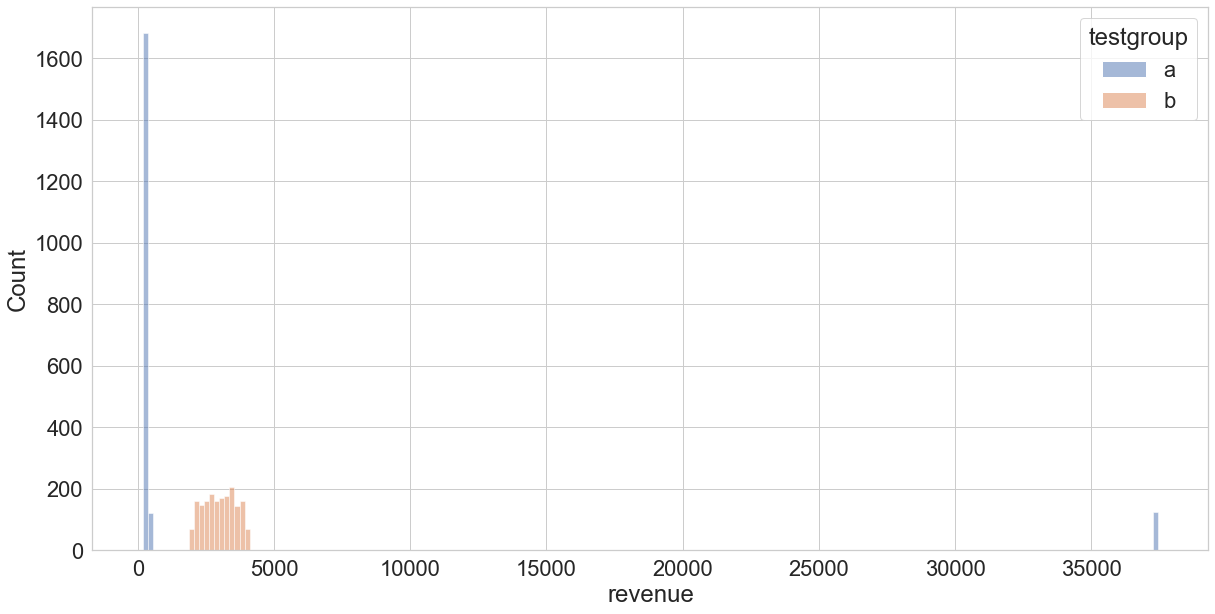

In [11]:
"""

Посмотрим на распределения в группах
    
"""
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,10)}
        )

sns.histplot(
    data=groups.query('revenue > 0'), 
    x="revenue",
    hue='testgroup',
    bins=200
            )

In [12]:
"""

в тестовой группе суммы распределены более равномерно в небольшом диапазоне,
в контрольной группе напротив, разброс большой и большенство значений лежат ближе к нулю, однако есть и достаточно большие суммы


"""

groups.query('revenue > 0') \
      .groupby('testgroup') \
      .revenue \
      .describe() \
      .transpose()

testgroup,a,b
count,1928.000000,1805.000000
mean,2663.998444,3003.658172
std,9049.039763,572.619709
min,200.000000,2000.000000
25%,257.000000,2513.000000
50%,311.000000,3022.000000
75%,361.000000,3478.000000
max,37433.000000,4000.000000


In [13]:
"""

Можно посмотреть соотношение мелких покупателей и крупных, 
какой процент они составляют от числа купивших пользователей в группе "a"


"""

(
    groups.query('testgroup == "a" and revenue > 30000').user_id.nunique() 
    / 
    groups.query('testgroup == "a" and revenue > 0').user_id.nunique() 
    * 100
)

6.379668049792531

In [14]:
"""

Всего 6 процентов пользователей купили на крупнную сумму.
Посмотрим соотношения сумм покупок этих же типов покупателей


"""

(
    groups.query('testgroup == "a" and revenue > 30000').revenue.sum() 
    / 
    groups.query('testgroup == "a" and revenue > 0').revenue.sum()
    * 100
)

89.37077665950378

In [15]:
groups.query('testgroup == "a" and revenue > 0 and revenue < 30000').revenue.describe()

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

In [16]:
"""

Получается что в контрольной группе у нас около 6% пользователей совершали крупные покупки 
на суммы более 30000, составляющие 89% процентов от всей выручки.

В то время как в тестовой группе все покупатели делали покупки в относительно узком диапазоне на суммы от 2000 до 4000.

Давайте выберем стат метод, и сформируем гипотезы.

Для проверки гипотез т тест нам не пойдойдет из за больших выбросов в группе "а" 
и совсем не нормальном распределении в этой группе.

Критерий Манна Уитни сложен в интерпретации и, для сравнения arpu групп не подойдет,
так как у нас очень много нулевых значений

Будем использовать bootstrap.
Определим порог p-value в 0.05.
Мы устанавливаем порог уровня значимости таким, потому что, 
в данном случае результат отклонения нулевой гипотезы нас будет устраивать, 
если вероятность допустить ошибку первого рода будет меньше 5%


"""

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2)) 
           
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = ss.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = ss.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= ci.iloc[0][0] or abs(bar.get_x()) >= ci.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=100,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/10000 [00:00<?, ?it/s]

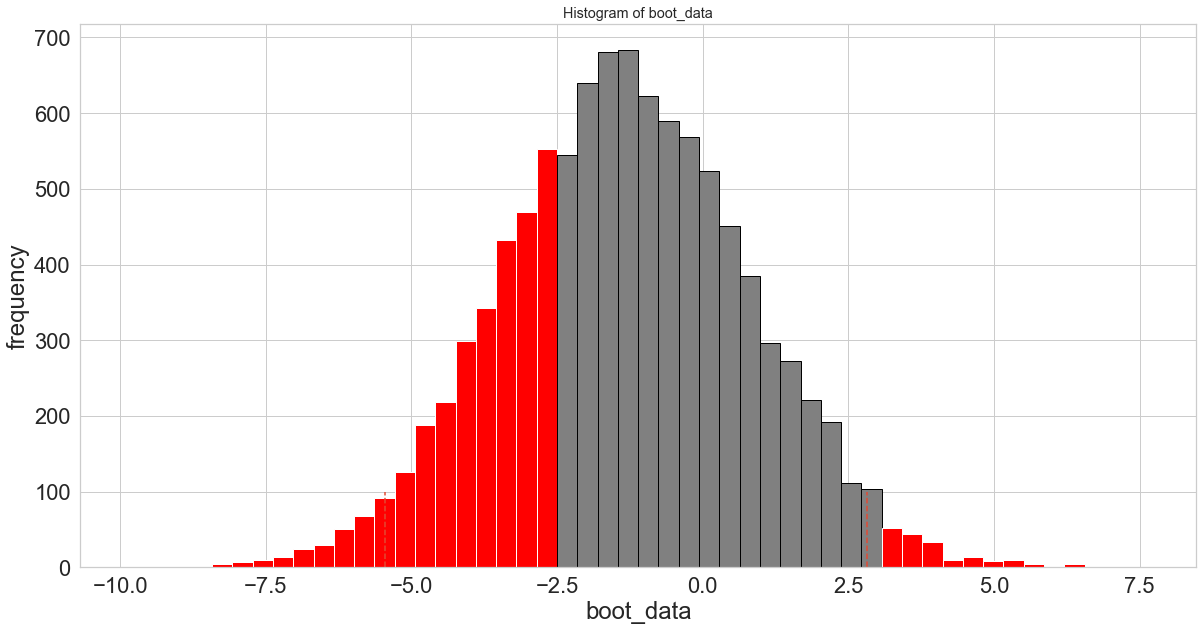

 Доверительный интервал 
              0
0.025 -5.451403
0.975  2.818568
p-value = 0.5320909611763676


In [17]:
"""

Для сравнения групп метрика ARPU нам подойдет.

Проведем сравнение групп по ARPU

Определим гипотезы:
H0 - Различий в ARPU в группах нет
H1 - Различия в ARPU наших групп есть

Порог значимости p-value - 0.05

"""


bootstraped_data = get_bootstrap(
    groups.query('testgroup == "a"').revenue, 
    groups.query('testgroup == "b"').revenue, 
    boot_it = 10000, 
    statistic = np.mean
)

print(f" Доверительный интервал \n{bootstraped_data['ci']}")
print(f"p-value = {bootstraped_data['p_value']}")

  0%|          | 0/10000 [00:00<?, ?it/s]

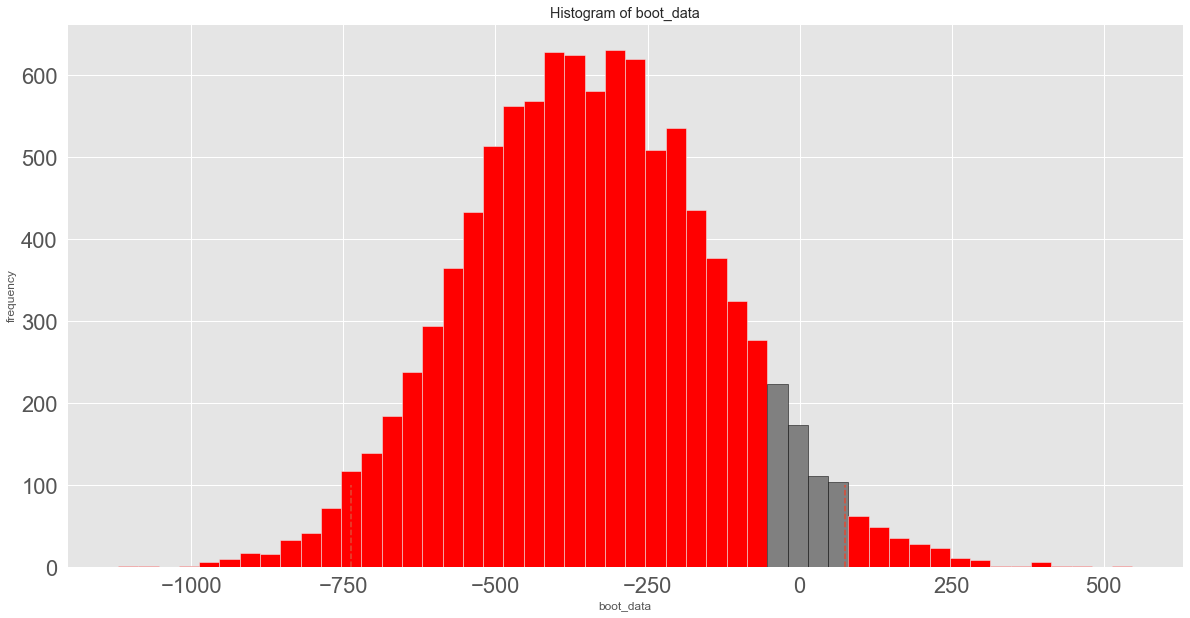

 Доверительный интервал 
                0
0.025 -738.094619
0.975   74.147484
p-value = 0.10097675041127974


In [178]:
"""

Вдими что 0 входит в доверительный интревал, пороговое значение p-value > 0.05, поэтому отклонить нулевую гипотезу 
о равенстве ARPU мы не можем.

Давайте посмотрим тоже самое для платящих пользователей

"""

bootstraped_data = get_bootstrap(
    groups.query('testgroup == "a" and revenue > 0').revenue, 
    groups.query('testgroup == "b" and revenue > 0').revenue, 
    boot_it = 10000, 
    statistic = np.mean
)

print(f" Доверительный интервал \n{bootstraped_data['ci']}")
print(f"p-value = {bootstraped_data['p_value']}")

  0%|          | 0/10000 [00:00<?, ?it/s]

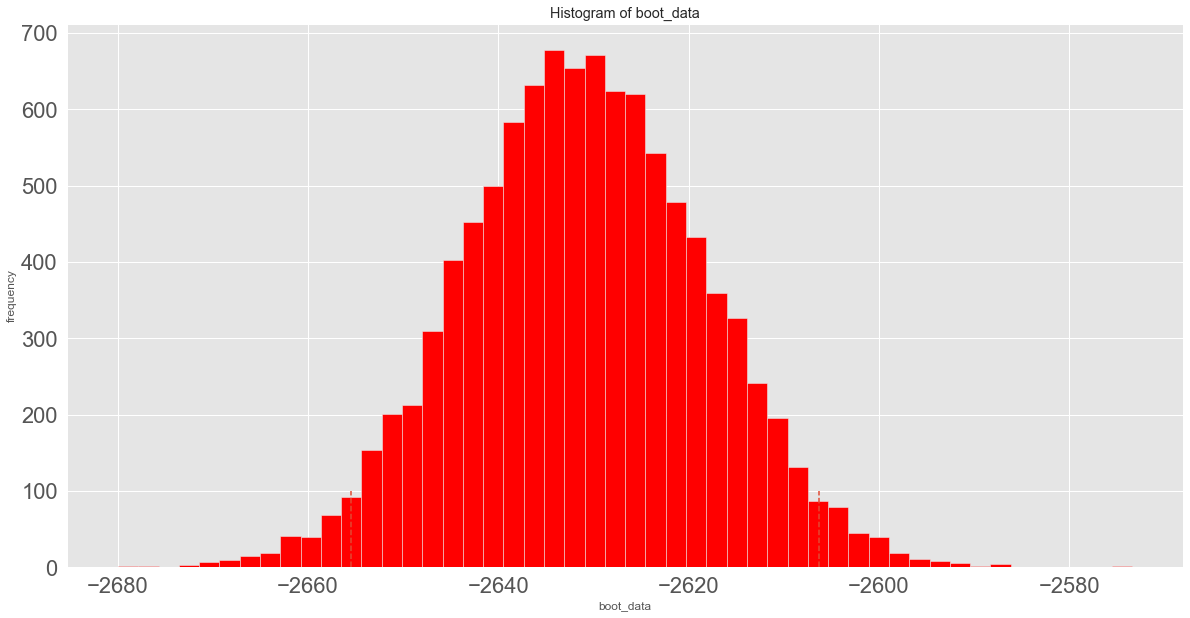

 Доверительный интервал 
                 0
0.025 -2655.531026
0.975 -2606.248238
p-value = 0.0


In [200]:
"""

Вдими что 0 входит в доверительный интревал, пороговое значение p-value > 0.05, поэтому и тут мы не можем принять гипотезу
о разности средних значений

Как мы помним что около 6% наших пользователей в контрольной группе делали покупки на относительно большие суммы.
Проверим гипотезу о том что 93% платящих пользователей контрольной группы, платят заметно меньше чем 93% платящих 
пользователей тестовой группы.

H0 - ARPPU 93% пользователей контрольной и тестовой группы не имеет различий
H1 - ARPPU 93% пользователей контрольной и тестовой группы имеет различия

"""

quantile_93_grp_a = groups.query('testgroup == "a" and revenue > 0').revenue.quantile(q=0.93)
quantile_93_grp_b = groups.query('testgroup == "b" and revenue > 0').revenue.quantile(q=0.93)


bootstraped_data = get_bootstrap(
    groups.query('testgroup == "a" and revenue > 0 and revenue < @quantile_93_grp_a').revenue, 
    groups.query('testgroup == "b" and revenue > 0 and revenue < @quantile_93_grp_b').revenue, 
    boot_it = 10000, 
    statistic = np.mean
)

print(f" Доверительный интервал \n{bootstraped_data['ci']}")
print(f"p-value = {bootstraped_data['p_value']}")

Видим что 0 не входит в наш доверительный интервал, и мы можем сказать что 93% платящих пользователей контрольной группы платят сильно меньше чем 93% платящих пользователей тестовой группы

Сравнивать конверсии я думаю не имеет смысла, так как мы не сможем оценить только по выручке, не зная показов акционных товаров, рекламных наборов, количество покупок каждым пользователем.

###### Вывод.

Мы доказали что в ARPU наших групп мы не можем найти различий. Но структуры групп отличаются, в тестовой группе все пользователи делают покупки на средние суммы в узком диапазоне от 2 тысяч до 4 тысяч. А в контрольной группе мы имеем 93.63% платящих пользователей которые делают покупки на мелкие суммы от 200 до 400 и 6.37% платящих пользователей которые делают крупные покупки на суммы более 30 тысяч и выручка которых составляет основную часть 89.37%.

И решение принимать тут в зависимости от бизнеса, задач и проблем которые мы хотим решать и т.д. какие покупатели для нас предпочтительнее или с кем легче работать. Вариант с тестовой группой имеет меньшие риски при потере пользователей, когда контрольный вариант нацелен на работу с крупными покупателями и при потере таких пользователей получим резкое снижение выручки и метрик.

##### Задание 3.

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Для оценки игрового дизайна события можно использовать:
- все конверсии по воронке уровней ивента
- количество игроков, которые начали и закончили эвент целиком и их процент от активной аудитории
- среднее время прохождения каждого уровня
- среднее количество попыток на прохождение каждого уровня

Для общей оценки, метрики лояльности и денежные метрики
- DAU, WAU, stickness
- retention, churn
- среднее время проведенное в игре
- доход, ARPU, ARPPU, ARPAU
- конверсия в покупку

Для усложненной механики все перечисленные метрики выше нам подходят.
